In [24]:
import gzip
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import multiprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

In [25]:
def read_fasta_to_df(file) -> pd.DataFrame:
    """
    method for reading in fasta file and converting it to a pandas dataframe
    """
    fasta_dict = {"Entry": "Sequence"}
    with open(file, "r") as f:
        lines = f.readlines()
    current_key = ""
    for line in lines:
        line = line.strip("\n")
        if line[0] == ">":
            fasta_dict[line[1::]] = ""
            current_key = line[1::]
        else:
            fasta_dict[current_key] += line
    f.close()

    # Set the first row as column names
    df = pd.DataFrame.from_dict(fasta_dict, orient="index")
    df.columns = df.iloc[0]
    df = df[1:]
    return df


In [26]:
def filter_unwanted_seqs(df: pd.DataFrame, enzymes=bool):

    # remove unwanted aas
    df = df[~df['Sequence'].str.contains('O')]
    df = df[~df['Sequence'].str.contains('U')]

    # for enzymes remove multifunctional enzymes
    if enzymes:
        multifunc_enzymes = df[df['EC number'].str.contains(';')]
        to_remove = []
        for ec in multifunc_enzymes['EC number']:
            ec = ec.split(';')
            if ec[0][0] != ec[1][0]:
                to_remove.append(ec)
        df = df[~df['EC number'].isin(to_remove)]

    return df



MSPKSVPDIGDVLARQAEDIDTRYHPSAALRRQLNKVFPTHWSFLLGEIALYSFIVLLLTGVYLTLFFDPSMTDVTYNGVYQPLRGVEMSRAYQSTLDISFEVRGGLFVRQIHHWAALMFTAAIMVHLARIFFTGAFRRPRETNWVIGSLLLILAMFEGYFGYSMPDDLLSGIGLRAALSSITLGIPVIGTWLHWALFGGDFPGTILIPRLYALHILLIPGVILALIGLHLALVWFQKHTQFPGPGRTEYNVVGVRVMPVFAFKSGAFFAAIVGVLGLMGGFLQINPIWNLGPYKPSQVSAGSQPDFYMMWTEGLARIWPAWEFYFWHHTIPAPVWVAVIMALVFVLLITYPFLEKRFTGDYAHHNLLQRPRDVPVRTSIGAMAITFYMVLTLAAMNDIIALKFHISLNATTWIGRIGMVILPLLVYFITYRWCIGLQRSDRAVLEHGIETGIIKRLPHGAYIELHQPLGPVDDHGHPIPLEYQGTAVPKRMNKLGSAGSPSSGSFLFADPVSEDAALREATHVAEQRALTALREHQDSIASSPNGERGKH
1


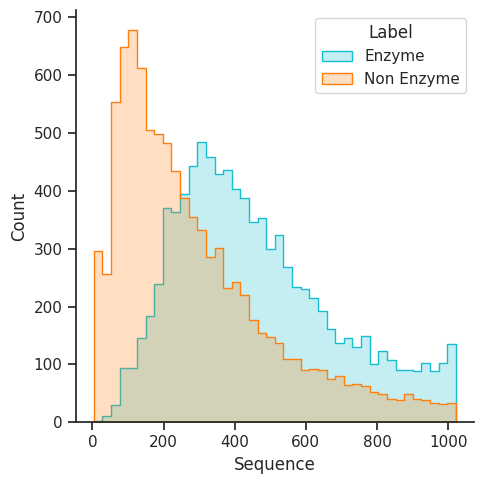

In [40]:
enzymes = pd.read_csv("/home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv", sep=",")
non_enzymes = read_fasta_to_df("/home/malte/Desktop/Dataset/data/non_enzyme/fasta/no_enzyme_train.fasta")

enzymes = filter_unwanted_seqs(df=enzymes, enzymes=True)
enzymes.set_index("Entry", inplace=True)
non_enzymes = filter_unwanted_seqs(df=non_enzymes, enzymes=False)
non_enzymes = non_enzymes[non_enzymes["Sequence"].apply(len) <= 1022]
# sns.displot(non_enzymes, x=non_enzymes["Sequence"].apply(len), element="step")
non_enzymes = non_enzymes[non_enzymes["Sequence"].apply(len) <= 1022]

# plt.hist(enzymes["Sequence"].apply(len), bins=60)
# fill in y label
enzymes["Label"] = 1
non_enzymes["Label"] = -1
non_enzymes["EC number"] = -1


# filter short sequences and make dfs equally big
# enzymes = enzymes[enzymes["Sequence"].apply(len) > 200]
# non_enzymes = non_enzymes[non_enzymes["Sequence"].apply(len) > 200]
non_enzymes = non_enzymes.sample(len(enzymes), random_state=42)

# combine df to main dataframe for knn
df = pd.concat([enzymes, non_enzymes])
palette = {1: "tab:cyan", -1: "tab:orange"}
sns.displot(df, x=df["Sequence"].apply(len), hue="Label", element="step", palette=palette, legend=False)
plt.legend(title='Label', loc='upper right', labels=['Enzyme', 'Non Enzyme'])

train_x, test_x, train_y, test_y = train_test_split(df["Sequence"], df["Label"], random_state=42, test_size=0.3)

print(train_x[0])
print(train_y[0])

train_x_list = train_x.tolist()
test_x_list = test_x.tolist()

NUM_PROCESSES = 16



In [41]:
print(len(enzymes))
print(len(non_enzymes))

9186
9186


In [14]:
def ncd(x:str, x2:str):
    x_compressed = len(gzip.compress(x.encode()))
    x2_compressed = len(gzip.compress(x2.encode()))
    xx2 = len(gzip.compress((" ".join([x,x2])).encode()))
    return (xx2 - min(x_compressed, x2_compressed)) / max(x_compressed, x2_compressed)

In [15]:
# Initialize NCD matrices
train_ncd = [[0] * len(train_x_list) for _ in range(len(train_x_list))]
test_ncd = [[0] * len(train_x_list) for _ in range(len(test_x_list))]

In [16]:
# Helper function to compute NCD row
def calculate_ncd_row(data_row): # data row is a tuple of (index, text)
    i = data_row[0] # index of the data and data_row[1] is the text data
    # calcs the row of NCD values for the given data sample
    row = [ncd(data_row[1], train_x_list[j]) for j in range(len(train_x_list))]
    return i, row # return index and row's ncd values

In [17]:
with multiprocessing.Pool(NUM_PROCESSES) as pool:
    # Compute train NCD
    train_data = list(enumerate(train_x_list))
    train_results = pool.map(calculate_ncd_row, train_data)

    # Compute test NCD
    test_data = list(enumerate(test_x_list))
    test_results = pool.map(calculate_ncd_row, test_data)

In [18]:
# Insert rows into NCD matrices
for i, row in train_results:
    train_ncd[i] = row

for i, row in test_results:
    test_ncd[i] = row

In [29]:
# KNN classification
neigh = KNeighborsClassifier(n_neighbors=23)
neigh.fit(train_ncd, train_y)

accuracy = neigh.score(test_ncd, test_y)
print("Accuracy:", accuracy)

Accuracy: 0.6233040702314445


In [30]:
# Compute ROC curve and AUC

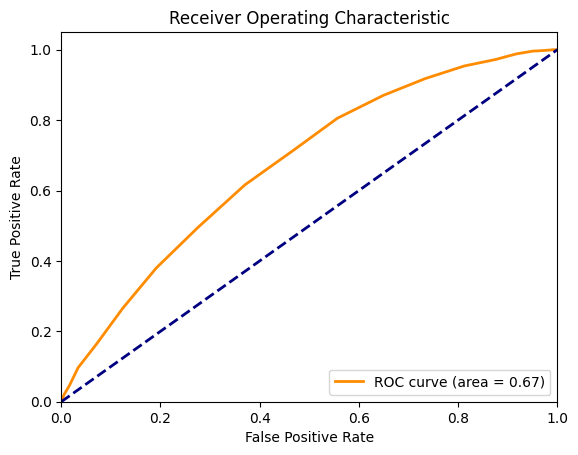

AUC: 0.6722405422538273


In [31]:
# Predict probabilities for the positive class (class 1)
y_prob = neigh.predict_proba(test_ncd)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_y, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)


In [22]:
k_val = ['3','5','7','9','11','13']
accs = [0.6852322206095791,
        0.6994188158372684,
        0.706277213352685,
        0.7135341074020319,
        0.7193396226415094,
        0.7177068214804064
        ]
aucs = [0.7327608168875566,
        0.7530599575534589,
        0.7676071682719114,
        0.7684117326044725,
        0.7785173028728516,
        0.7815764510563281
        ]

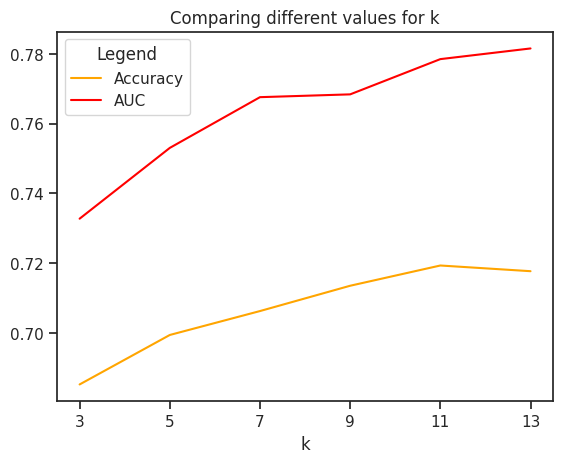

In [81]:
ax = sns.lineplot(x=k_val, y=accs, legend=False, color="orange")
sns.lineplot(x=k_val, y=aucs, legend=False, color="red")
ax.set_title("Comparing different values for k")
ax.set(xlabel="k")
plt.legend(title='Legend', loc='upper left', labels=['Accuracy', 'AUC'],
           handles=[plt.Line2D([], [], color='orange', label='Accuracy'),
                    plt.Line2D([], [], color='red', label='AUC')])
plt.show()


# Looking into the sequence compression and distance calculation

In [86]:
x = df["Sequence"][0]
print(f"SEQUENCE:\n---------\n{x}\nLENGTH: {len(x)}\n")
x_comp = gzip.compress(x.encode())
print(f"COMPRESSED SEQUENCE:\n--------------------\n{x_comp}\n")
print(f"LENGTH: {len(x_comp)}")

SEQUENCE:
---------
MPAPTQLFFPLVRNCELSRIYGTACYCHHKHLCCSPPYIPQNRLRYTPHPAYATFCRPRENWWQYTQGRRYASTPQKFYLTPPQVNSILKANEYSFKVPEFDGKNVSSILGFDSNRLPANAPIEDRRSATTCLQTRGMLLGVFDGHAGCACSQAVSERLFYYIAVSLLPHETLLEIENAVESGRALLPILQWHKHPNDYFSKEASKLYFNGLRTYWQELIDLNTGESADIDVKEALINAFKRLDNDISLEAQVGDPNSFLNYLVLRVAFSGATACVAHVDGVDLHVANTGDSRAMLGVQEEDGSWSAVTLSNDHNAQNERELQRLKLEHPKNEAKSVVKQDRLLGLLMPFRAFGDVKFKWSIDLQKRVIESGPDQLNDNEYTKFIPPNYHTPPYLTAEPEVTYHRLRPQDKFLVLATDGLWETMHRQDVVRIVGEYLTGMHHQQPIAVGGYKVTLGQMHGLLTERRAKMSSVFEDQNAATHLIRHAVGNNEFGAVDHERLSKMLSLPEELARMYRDDITIIVVQFNSHVVGAYQNQEQ
LENGTH: 538

COMPRESSED SEQUENCE:
--------------------
b'\x1f\x8b\x08\x00\x14n\xdbd\x02\xff\r\x90[\x0eE1\x04E\xc7&\x87jS\x15\x8f\xc6M\xe7?\x91\xebO\xd8aY\xc7\xc0\xae\xcb\x18&\x15\xfa\x91d\xac\xc7\x17\xbe\xf7\xcd\xb9\xa7|_\x9a\xbde\xae!\xf1\xaeM\x83\x07w|aA\xfa\xfb\xf9\xbb\xce\x11\x0f\xf2\x9a\xef\xf1\xe4\x9ayi.\xd9\xa0\xf4r\xec2\x1a\xc8[+\xbb\xc9\x03\xb3\x17\x19(\xd8"\x8cH\xb8\xf7\x13\xbf\xc1G\x84\xab\x93\x13\xf8\x83/\x1d*)d\xbc\xb7\xba\x

In [85]:
x2 = df["Sequence"][1]
print(f"SEQUENCE:\n---------\n{x2}\nLENGTH: {len(x2)}\n")
x2_comp = gzip.compress(x2.encode())
print(f"COMPRESSED SEQUENCE:\n--------------------\n{x2_comp}\n")
print(f"LENGTH: {len(x2_comp)}")

SEQUENCE:
---------
MRLGNAYAYCKPSQNVGLKLDLLRGLPGYVGHATSRINRLENQDNYSIKMMRSWPNAYGSALNCSVFDGHGEKGAQLSQLLADKLCSSLDFPEPSWDKQDLKKLVQEYARRFPEGNYWKHKLSTFEKFYNKFIKNCNSKQELLLMKEGDSAILGQNGGRMIFDKMGNIIDKIALLTELDRLRLFYGFARFDLDQCCGLGTAAGSTASSIFLYPYDDPNAPIDEGKDDDSWIISHSGLLKLIVTQVGDSKIILCDQDGIAHALTTTHHINSSRERHRLSIDPSRLDPDAFGETRFLNNFANTRSFGDVAGKPYGISSEPDIFSFLVGNTLHLPRSERSKLPFNGDECFLALVTDGITNKLADQEVVDLITSTVNSWGLKKATPQFVAEETIKFIQAIATKHSDNATCVVVRLSNWGNWPNVDRTGPQRETKLMNAQSNETKLN
LENGTH: 442

COMPRESSED SEQUENCE:
--------------------
b'\x1f\x8b\x08\x00\x0en\xdbd\x02\xff\x15\x90Q\x8aE1\x08C\xd7&\xb5\xb5b\xae\xb4*}t\xff\x1b\x99\xce_\x08\x84$\xe7\x0b\x88\xd3\xa5\xdbl\xe5\xf6#00\x10\x82%\xf7\xc8\xa4\xcaP\x0ft\xdf\xec7\xd5\xbe/\xf2\xb7^D\x92\xe0-\xcf`\x99\xd2Mh#7@lh\x99\xe0\xb1\xfa\xca\x1f\xdbf\x98\xe1\xec~)\xe2\x99\xe2\xf7g\xd3\x905\xba\x8d\xeb6\xd4\xbcy\xda\xee\x00>\xeb\xc2I\n\xd9.\x12\x9f\x0e\xb6O\\\x95M\t\xa8\x0e\x0e\x04\xc6\x95A1\x18\xbc[\x13H\x11I\x16e\xea\xc0]\x97\xf9-\\\xca]\x8c\x99\xf3\xa7\x9a3\x05\xef\

## Combining x and x2 to xx2

In [58]:
xx2_comp = gzip.compress(" ".join([x, x2]).encode())
print(f"COMPRESSED SEQUENCE:\n--------------------\n{xx2_comp}\n")
print(f"LENGTH: {len(xx2_comp)}")


COMPRESSED SEQUENCE:
--------------------
b'\x1f\x8b\x08\x00\x99a\xdbd\x02\xff\x1d\x93Q\xae\xed \x08E\xa7\xf2\xa6B\n\xa2\x81\x12\x04b\xe3\xfc\'r9\xef\xcfX\xaa\xb0\xf6\xf2u\xf0\xda:\x86\xeb\t{H3\xd6\xe5\x82\xe7>s\xca\xd4\xe7I\xf7\xbb|[h\xdc\xf2\xe9p\xa1\xc6\x13\x1ed\xdf\xb7om\x8e\xb8\x90\xe5[\xc6\xd5r\xdf\xc7r\xa9\x80\xd1\xcd!\xc7i \x8b\x9d\xecM\x1e\x98}\x90\x83\x81/\xc2\x88\x84\xaaGw\x05\xbf\xaa|\xbar\x02?\xf0\xe4\x86\x93\x14:\xee]\xbdR\xf5I\xa5J\x8b\x0c\x0e%\x07\xf4\xd6\xd2\xfdu\x8fnxG\nA\x8a\xdea\xacQ\xf7\xdb\xa4\x0b\xd5\x8a)\x01\x17\x9e\xfe\xac\xcb`H(\x1a\xaeT\x82}\x18\xddr\xa8]=\x1a\x07F2\xf4\xe4\x07\xe6A>\xa8\xf3@\x1f\x80\x19\xf0vo\x9b\x089\xbf\x84S\x9a\x86\xd3`\x1b\x05\xe9\x0e\x15\xa5\xe9b\x04\x92\xe7\xc8\xc6\xe8YT_\x1f\x01\x83\xfb\xee!_v7[\xe2\xacn\xdeq\xaba\xe3)\x19\xcb\xdd\xeelj\x8d\x0e\xc8\xe9\xd4\x9dM\xda7\xca\xe8\xae\xa0\x90\xf5\xa3zgl<\'\xd6a\xeaJ~\xe7\xdc\xdb\x1b\r\xf3\x95n\x88\xf7;\xfb\xca\xa2\x08\x907\xf3\x0c\xc2m\x005u\xc5\xec23\x1a\x0c\x07gCMy5\xd5\x89\x14\xe2\xbd\x81

## Calulating normalized compression distances

In [61]:
# saving lengths
x_comp_length = len(x_comp)
x2_comp_length = len(x2_comp)
xx2_comp_length = len(xx2_comp)


ncd = (xx2_comp_length - min(x_comp_length, x2_comp_length)) / max(x_comp_length, x2_comp_length)
print(f"Normalized compression distance: {ncd}")

Normalized compression distance: 0.9194029850746268


### Now we need to compare every sequence to every other sequence in the dataframe:

In [63]:
def ncd(x, x2):
  x_compressed = len(gzip.compress(x.encode()))
  x2_compressed = len(gzip.compress(x2.encode()))
  xx2 = len(gzip.compress((" ".join([x,x2])).encode()))
  return (xx2 - min(x_compressed, x2_compressed)) / max(x_compressed, x2_compressed)

In [64]:
example_df = df["Sequence"][1:10]
train_ncd = [[ncd(example_df[i], example_df[j]) for j in range(len(example_df))] for i in range(len(example_df))]

In [69]:
for i in range(len(train_ncd)):
    print(f"[{i}]: {train_ncd[i]}")

[0]: [0.04609929078014184, 0.900709219858156, 0.913312693498452, 0.9438669438669439, 0.9477124183006536, 0.9113475177304965, 0.9524714828897338, 0.8936170212765957, 0.8829787234042553]
[1]: [0.9078014184397163, 0.04285714285714286, 0.9256965944272446, 0.9584199584199584, 0.9651416122004357, 0.9142857142857143, 0.9524714828897338, 0.9071428571428571, 0.9]
[2]: [0.9164086687306502, 0.9256965944272446, 0.034055727554179564, 0.9584199584199584, 0.9564270152505446, 0.9287925696594427, 0.9562737642585551, 0.9071207430340558, 0.9009287925696594]
[3]: [0.9438669438669439, 0.9667359667359667, 0.9542619542619543, 0.037422037422037424, 0.9646569646569647, 0.9563409563409564, 0.9600760456273765, 0.9417879417879418, 0.9459459459459459]
[4]: [0.9477124183006536, 0.9651416122004357, 0.9586056644880174, 0.9667359667359667, 0.034858387799564274, 0.9455337690631809, 0.9657794676806084, 0.9498910675381264, 0.9368191721132898]
[5]: [0.9042553191489362, 0.9142857142857143, 0.9287925696594427, 0.96049896049